# Convert .odgt files to JSON files

In [5]:
import json
import os
from pathlib import Path

# Data path
data_path = Path("/workspace/data/crowdhuman")
output_path = data_path / "annotations_json"

# Create output directory if it doesn't exist
output_path.mkdir(parents=True, exist_ok=True)

# Find all .odgt files
odgt_files = list[Path](data_path.glob("*.odgt"))
print(f"Found {len(odgt_files)} .odgt files:")
for f in odgt_files:
    print(f"  - {f.name}")


Found 2 .odgt files:
  - annotation_train.odgt
  - annotation_val.odgt


In [6]:
def convert_odgt_to_json(odgt_file, output_dir):
    """
    Convert .odgt file to individual JSON files, one per image ID.
    
    Args:
        odgt_file: Path to .odgt file
        output_dir: Directory to save JSON files
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    count = 0
    errors = 0
    
    with open(odgt_file, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue
                
            try:
                # Parse JSON from each line
                annotation = json.loads(line)
                
                # Extract image ID
                image_id = annotation.get('ID', f'unknown_{line_num}')
                
                # Create safe filename (replace problematic characters)
                safe_filename = image_id.replace(',', '_').replace('/', '_')
                json_filename = f"{safe_filename}.json"
                json_path = output_dir / json_filename
                
                # Save as formatted JSON
                with open(json_path, 'w', encoding='utf-8') as json_file:
                    json.dump(annotation, json_file, indent=2, ensure_ascii=False)
                
                count += 1
                
            except json.JSONDecodeError as e:
                print(f"Error parsing line {line_num} in {odgt_file.name}: {e}")
                errors += 1
            except Exception as e:
                print(f"Error processing line {line_num} in {odgt_file.name}: {e}")
                errors += 1
    
    return count, errors

# Process all .odgt files
total_converted = 0
total_errors = 0

for odgt_file in odgt_files:
    print(f"\nProcessing {odgt_file.name}...")
    
    # Create subdirectory for each .odgt file
    subdir_name = odgt_file.stem  # filename without extension
    subdir = output_path / subdir_name
    subdir.mkdir(parents=True, exist_ok=True)
    
    count, errors = convert_odgt_to_json(odgt_file, subdir)
    total_converted += count
    total_errors += errors
    
    print(f"  Converted: {count} files")
    if errors > 0:
        print(f"  Errors: {errors}")

print(f"\n{'='*50}")
print(f"Total converted: {total_converted} JSON files")
print(f"Total errors: {total_errors}")
print(f"Output directory: {output_path}")



Processing annotation_train.odgt...
  Converted: 15000 files

Processing annotation_val.odgt...
  Converted: 4370 files

Total converted: 19370 JSON files
Total errors: 0
Output directory: /workspace/data/crowdhuman/annotations_json


In [7]:
# Verify conversion - show example files
print("Example converted files:")
print(f"\nOutput directory structure:")
for subdir in output_path.iterdir():
    if subdir.is_dir():
        json_files = list(subdir.glob("*.json"))
        print(f"\n  {subdir.name}/ ({len(json_files)} files)")
        if json_files:
            # Show first file as example
            example_file = json_files[0]
            print(f"    Example: {example_file.name}")
            
            # Show content of first file
            with open(example_file, 'r', encoding='utf-8') as f:
                example_data = json.load(f)
                print(f"    ID: {example_data.get('ID', 'N/A')}")
                print(f"    Number of gtboxes: {len(example_data.get('gtboxes', []))}")
                if example_data.get('gtboxes'):
                    first_box = example_data['gtboxes'][0]
                    print(f"    First gtbox tag: {first_box.get('tag', 'N/A')}")


Example converted files:

Output directory structure:

  annotation_train/ (15000 files)
    Example: 284193_faa9000f2678b5e.json
    ID: 284193,faa9000f2678b5e
    Number of gtboxes: 7
    First gtbox tag: person

  annotation_val/ (4370 files)
    Example: 273271_c9db000d5146c15.json
    ID: 273271,c9db000d5146c15
    Number of gtboxes: 6
    First gtbox tag: person


In [10]:
# === GLOBAL NOTEBOOK SETUP CELL ===

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import imagehash
import json
from pathlib import Path
import os
from collections import defaultdict

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directory
OUTPUT_DIR = Path("./eda_outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Define paths
IMAGE_DIR = Path("/workspace/data/crowdhuman/Images")
ANN_PATH = Path("/workspace/data/crowdhuman/annotations_json")

print(f"IMAGE_DIR: {IMAGE_DIR}")
print(f"ANN_PATH: {ANN_PATH}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")


IMAGE_DIR: /workspace/data/crowdhuman/Images
ANN_PATH: /workspace/data/crowdhuman/annotations_json
OUTPUT_DIR: eda_outputs


In [15]:
# === STEP 1: Dataset Schema Validation Cell ===

invalid_images = []
empty_annotations = []
invalid_bboxes = []
all_annotations = []

# Load all annotation files
for split_dir in [ANN_PATH / "annotation_train", ANN_PATH / "annotation_val"]:
    if not split_dir.exists():
        continue
    for ann_file in split_dir.glob("*.json"):
        try:
            with open(ann_file, 'r') as f:
                ann_data = json.load(f)
            
            image_id = ann_data.get('ID', '')
            gtboxes = ann_data.get('gtboxes', [])
            
            # Check empty annotations
            if len(gtboxes) == 0:
                empty_annotations.append({
                    'image_id': image_id,
                    'annotation_file': str(ann_file)
                })
                continue
            
            # Check image existence - try with comma first (actual format), then underscore
            image_path = None
            for filename_variant in [image_id, image_id.replace(',', '_')]:
                for ext in ['.jpg', '.png']:
                    test_path = IMAGE_DIR / f"{filename_variant}{ext}"
                    if test_path.exists():
                        image_path = test_path
                        break
                if image_path:
                    break
            
            if image_path is None or not image_path.exists():
                invalid_images.append({
                    'image_id': image_id,
                    'expected_path': str(image_path),
                    'annotation_file': str(ann_file)
                })
                continue
            
            # Validate bboxes
            try:
                img = cv2.imread(str(image_path))
                if img is None:
                    invalid_images.append({
                        'image_id': image_id,
                        'reason': 'Cannot read image',
                        'annotation_file': str(ann_file)
                    })
                    continue
                
                img_h, img_w = img.shape[:2]
                
                for idx, box in enumerate(gtboxes):
                    for box_type in ['vbox', 'fbox', 'hbox']:
                        if box_type in box:
                            bbox = box[box_type]
                            if len(bbox) != 4:
                                invalid_bboxes.append({
                                    'image_id': image_id,
                                    'box_idx': idx,
                                    'box_type': box_type,
                                    'reason': 'Invalid length',
                                    'value': bbox
                                })
                                continue
                            
                            x, y, w, h = bbox
                            if w <= 0 or h <= 0:
                                invalid_bboxes.append({
                                    'image_id': image_id,
                                    'box_idx': idx,
                                    'box_type': box_type,
                                    'reason': 'Non-positive dimensions',
                                    'value': bbox
                                })
                            if x < 0 or y < 0:
                                invalid_bboxes.append({
                                    'image_id': image_id,
                                    'box_idx': idx,
                                    'box_type': box_type,
                                    'reason': 'Negative coordinates',
                                    'value': bbox
                                })
                
                all_annotations.append({
                    'image_id': image_id,
                    'image_path': str(image_path),
                    'num_boxes': len(gtboxes),
                    'img_w': img_w,
                    'img_h': img_h,
                    'annotation_file': str(ann_file),
                    'gtboxes': gtboxes
                })
            except Exception as e:
                invalid_images.append({
                    'image_id': image_id,
                    'reason': str(e),
                    'annotation_file': str(ann_file)
                })
        except Exception as e:
            invalid_images.append({
                'image_id': 'unknown',
                'reason': f'Parse error: {str(e)}',
                'annotation_file': str(ann_file)
            })

# Save invalid images
if invalid_images:
    df_invalid = pd.DataFrame(invalid_images)
    df_invalid.to_csv(OUTPUT_DIR / "invalid_images.csv", index=False)
    print(f"Invalid images: {len(invalid_images)}")
    print(df_invalid.head())
else:
    print("No invalid images found")

# Save empty annotations
if empty_annotations:
    df_empty = pd.DataFrame(empty_annotations)
    df_empty.to_csv(OUTPUT_DIR / "empty_annotations.csv", index=False)
    print(f"\nEmpty annotations: {len(empty_annotations)}")
    print(df_empty.head())
else:
    print("\nNo empty annotations found")

print(f"\nTotal valid annotations loaded: {len(all_annotations)}")

No invalid images found

No empty annotations found

Total valid annotations loaded: 19370


In [16]:
# === STEP 2: Class & Instance Distribution Cell ===

if len(all_annotations) == 0:
    print("WARNING: No annotations loaded. Please check Step 1.")
    df_class = pd.DataFrame(columns=['class', 'count'])
    objects_per_image = []
else:
    class_counts = defaultdict(int)
    objects_per_image = []

    for ann in all_annotations:
        num_objects = 0
        for box in ann['gtboxes']:
            tag = box.get('tag', 'unknown')
            if tag == 'person':
                class_counts['person'] += 1
                num_objects += 1
            elif tag == 'mask':
                class_counts['mask'] += 1
            else:
                class_counts[tag] += 1
                num_objects += 1
        objects_per_image.append(num_objects)

    # Class distribution
    df_class = pd.DataFrame(list(class_counts.items()), columns=['class', 'count'])
    df_class = df_class.sort_values('count', ascending=False)

    if len(df_class) > 0:
        plt.figure(figsize=(10, 6))
        plt.bar(df_class['class'], df_class['count'])
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.title('Class Distribution')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / "class_distribution.png", dpi=150, bbox_inches='tight')
        plt.close()

    # Objects per image
    if len(objects_per_image) > 0:
        df_objects = pd.DataFrame({'objects_per_image': objects_per_image})

        plt.figure(figsize=(10, 6))
        plt.hist(objects_per_image, bins=50, edgecolor='black')
        plt.xlabel('Number of Objects per Image')
        plt.ylabel('Frequency')
        plt.title('Objects per Image Distribution')
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / "objects_per_image.png", dpi=150, bbox_inches='tight')
        plt.close()

print("Class Distribution:")
print(df_class)
if len(objects_per_image) > 0:
    print(f"\nObjects per image - Mean: {np.mean(objects_per_image):.2f}, Median: {np.median(objects_per_image):.2f}, Max: {np.max(objects_per_image)}")
else:
    print("\nNo objects found in annotations.")


Class Distribution:
    class   count
0  person  456098
1    mask  110410

Objects per image - Mean: 23.55, Median: 16.00, Max: 391


In [17]:
# === STEP 3: Bounding Box Scale & Aspect Ratio Cell ===

bbox_area_ratios = []
aspect_ratios = []

for ann in all_annotations:
    img_area = ann['img_w'] * ann['img_h']
    for box in ann['gtboxes']:
        if 'fbox' in box:
            x, y, w, h = box['fbox']
            bbox_area = w * h
            area_ratio = bbox_area / img_area if img_area > 0 else 0
            bbox_area_ratios.append(area_ratio)
            
            if h > 0:
                aspect_ratio = w / h
                aspect_ratios.append(aspect_ratio)

# Bbox area ratio histogram
plt.figure(figsize=(10, 6))
plt.hist(bbox_area_ratios, bins=100, edgecolor='black')
plt.xlabel('Bounding Box Area Ratio (bbox_area / image_area)')
plt.ylabel('Frequency')
plt.title('Bounding Box Area Ratio Distribution')
plt.yscale('log')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "bbox_area_ratio_hist.png", dpi=150, bbox_inches='tight')
plt.close()

# Aspect ratio histogram
plt.figure(figsize=(10, 6))
plt.hist(aspect_ratios, bins=100, edgecolor='black', range=(0, 3))
plt.xlabel('Aspect Ratio (width / height)')
plt.ylabel('Frequency')
plt.title('Aspect Ratio Distribution')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "aspect_ratio_hist.png", dpi=150, bbox_inches='tight')
plt.close()

print(f"Bbox area ratio - Mean: {np.mean(bbox_area_ratios):.4f}, Median: {np.median(bbox_area_ratios):.4f}")
print(f"Aspect ratio - Mean: {np.mean(aspect_ratios):.4f}, Median: {np.median(aspect_ratios):.4f}")


Bbox area ratio - Mean: 0.0345, Median: 0.0067
Aspect ratio - Mean: 0.5762, Median: 0.4000


In [18]:
# === STEP 4: Spatial Heatmap Cell ===

center_points = []

for ann in all_annotations:
    img_w = ann['img_w']
    img_h = ann['img_h']
    for box in ann['gtboxes']:
        if 'fbox' in box:
            x, y, w, h = box['fbox']
            center_x = x + w / 2
            center_y = y + h / 2
            # Normalize to [0, 1]
            center_points.append([center_x / img_w, center_y / img_h])

if center_points:
    centers = np.array(center_points)
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    hb = ax.hexbin(centers[:, 0], centers[:, 1], gridsize=50, cmap='YlOrRd', mincnt=1)
    ax.set_xlabel('Normalized X Coordinate')
    ax.set_ylabel('Normalized Y Coordinate')
    ax.set_title('Bounding Box Center Point Heatmap')
    plt.colorbar(hb, ax=ax, label='Count')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "bbox_center_heatmap.png", dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"Total center points: {len(center_points)}")


Total center points: 566508


In [19]:
# === STEP 5: CrowdHuman-Specific Crowding & Occlusion Cell ===

def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    x1_min, y1_min = x1, y1
    x1_max, y1_max = x1 + w1, y1 + h1
    x2_min, y2_min = x2, y2
    x2_max, y2_max = x2 + w2, y2 + h2
    
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)
    
    if inter_x_max <= inter_x_min or inter_y_max <= inter_y_min:
        return 0.0
    
    inter_area = (inter_x_max - inter_x_min) * (inter_y_max - inter_y_min)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area
    
    if union_area == 0:
        return 0.0
    
    return inter_area / union_area

iou_values = []
occlusion_scores = []
truncation_rates = []

for ann in all_annotations:
    img_w = ann['img_w']
    img_h = ann['img_h']
    boxes = []
    
    for box in ann['gtboxes']:
        if 'fbox' in box:
            boxes.append(box['fbox'])
    
    if len(boxes) < 2:
        continue
    
    # Calculate pairwise IoU
    image_ious = []
    for i in range(len(boxes)):
        for j in range(i + 1, len(boxes)):
            iou = calculate_iou(boxes[i], boxes[j])
            image_ious.append(iou)
            iou_values.append(iou)
    
    # Occlusion proxy: mean of max IoU per box
    if image_ious:
        max_ious = []
        for i in range(len(boxes)):
            max_iou = 0
            for j in range(len(boxes)):
                if i != j:
                    iou = calculate_iou(boxes[i], boxes[j])
                    max_iou = max(max_iou, iou)
            max_ious.append(max_iou)
        occlusion_scores.append(np.mean(max_ious))
    
    # Truncation rate
    truncated = 0
    for box in boxes:
        x, y, w, h = box
        if x < 0 or y < 0 or (x + w) > img_w or (y + h) > img_h:
            truncated += 1
    truncation_rate = truncated / len(boxes) if len(boxes) > 0 else 0
    truncation_rates.append(truncation_rate)

# IoU distribution
if iou_values:
    plt.figure(figsize=(10, 6))
    plt.hist(iou_values, bins=50, edgecolor='black', range=(0, 1))
    plt.xlabel('IoU')
    plt.ylabel('Frequency')
    plt.title('Pairwise IoU Distribution')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "iou_distribution.png", dpi=150, bbox_inches='tight')
    plt.close()

# Occlusion score histogram
if occlusion_scores:
    plt.figure(figsize=(10, 6))
    plt.hist(occlusion_scores, bins=50, edgecolor='black')
    plt.xlabel('Occlusion Score (mean max IoU per box)')
    plt.ylabel('Frequency')
    plt.title('Occlusion Score Distribution')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "occlusion_score_hist.png", dpi=150, bbox_inches='tight')
    plt.close()

# Truncation rate
if truncation_rates:
    plt.figure(figsize=(10, 6))
    plt.hist(truncation_rates, bins=50, edgecolor='black')
    plt.xlabel('Truncation Rate')
    plt.ylabel('Frequency')
    plt.title('Truncation Rate Distribution')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "truncation_rate.png", dpi=150, bbox_inches='tight')
    plt.close()

print(f"IoU values - Mean: {np.mean(iou_values):.4f}, Max: {np.max(iou_values):.4f}")
print(f"Occlusion scores - Mean: {np.mean(occlusion_scores):.4f}")
print(f"Truncation rates - Mean: {np.mean(truncation_rates):.4f}")


IoU values - Mean: 0.0102, Max: 0.9857
Occlusion scores - Mean: 0.2794
Truncation rates - Mean: 0.2193


In [20]:
# === STEP 5.5: Extra & Head Attribute Analysis Cell ===

extra_ignore_flags = []
extra_occ_levels = []
head_ignore_flags = []
head_occ_levels = []
head_unsure_flags = []
tag_distribution = {'person': 0, 'mask': 0}

for ann in all_annotations:
    for box in ann['gtboxes']:
        tag = box.get('tag', 'unknown')
        if tag in tag_distribution:
            tag_distribution[tag] += 1
        
        # Analyze extra attributes
        if 'extra' in box and box['extra']:
            extra = box['extra']
            if 'ignore' in extra:
                extra_ignore_flags.append(extra['ignore'])
            if 'occ' in extra:
                extra_occ_levels.append(extra['occ'])
        
        # Analyze head_attr
        if 'head_attr' in box and box['head_attr']:
            head_attr = box['head_attr']
            if 'ignore' in head_attr:
                head_ignore_flags.append(head_attr['ignore'])
            if 'occ' in head_attr:
                head_occ_levels.append(head_attr['occ'])
            if 'unsure' in head_attr:
                head_unsure_flags.append(head_attr['unsure'])

# Plot extra ignore flags
if extra_ignore_flags:
    plt.figure(figsize=(10, 6))
    ignore_counts = pd.Series(extra_ignore_flags).value_counts().sort_index()
    plt.bar(ignore_counts.index.astype(str), ignore_counts.values)
    plt.xlabel('Ignore Flag (0=not ignored, 1=ignored)')
    plt.ylabel('Count')
    plt.title('Extra Ignore Flag Distribution')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "extra_ignore_distribution.png", dpi=150, bbox_inches='tight')
    plt.close()

# Plot extra occlusion levels
if extra_occ_levels:
    plt.figure(figsize=(10, 6))
    plt.hist(extra_occ_levels, bins=20, edgecolor='black')
    plt.xlabel('Occlusion Level (from extra)')
    plt.ylabel('Frequency')
    plt.title('Extra Occlusion Level Distribution')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "extra_occ_distribution.png", dpi=150, bbox_inches='tight')
    plt.close()

# Plot head ignore flags
if head_ignore_flags:
    plt.figure(figsize=(10, 6))
    head_ignore_counts = pd.Series(head_ignore_flags).value_counts().sort_index()
    plt.bar(head_ignore_counts.index.astype(str), head_ignore_counts.values)
    plt.xlabel('Head Ignore Flag (0=not ignored, 1=ignored)')
    plt.ylabel('Count')
    plt.title('Head Ignore Flag Distribution')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "head_ignore_distribution.png", dpi=150, bbox_inches='tight')
    plt.close()

# Plot head occlusion levels
if head_occ_levels:
    plt.figure(figsize=(10, 6))
    plt.hist(head_occ_levels, bins=20, edgecolor='black')
    plt.xlabel('Head Occlusion Level (from head_attr)')
    plt.ylabel('Frequency')
    plt.title('Head Occlusion Level Distribution')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "head_occ_distribution.png", dpi=150, bbox_inches='tight')
    plt.close()

# Plot head unsure flags
if head_unsure_flags:
    plt.figure(figsize=(10, 6))
    unsure_counts = pd.Series(head_unsure_flags).value_counts().sort_index()
    plt.bar(unsure_counts.index.astype(str), unsure_counts.values)
    plt.xlabel('Head Unsure Flag')
    plt.ylabel('Count')
    plt.title('Head Unsure Flag Distribution')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "head_unsure_distribution.png", dpi=150, bbox_inches='tight')
    plt.close()

print(f"Tag distribution: {tag_distribution}")
print(f"Extra ignore flags - Total: {len(extra_ignore_flags)}, Ignored: {sum(extra_ignore_flags)}")
print(f"Extra occlusion levels - Mean: {np.mean(extra_occ_levels):.2f}" if extra_occ_levels else "No extra occlusion data")
print(f"Head ignore flags - Total: {len(head_ignore_flags)}, Ignored: {sum(head_ignore_flags)}")
print(f"Head occlusion levels - Mean: {np.mean(head_occ_levels):.2f}" if head_occ_levels else "No head occlusion data")
print(f"Head unsure flags - Total: {len(head_unsure_flags)}, Unsure: {sum(head_unsure_flags)}")


Tag distribution: {'person': 456098, 'mask': 110410}
Extra ignore flags - Total: 136065, Ignored: 127462
Extra occlusion levels - Mean: 0.72
Head ignore flags - Total: 439046, Ignored: 8637
Head occlusion levels - Mean: 0.28
Head unsure flags - Total: 439046, Unsure: 3263


In [21]:
# === STEP 6: Image Quality Analysis Cell ===

brightness_scores = []
blur_scores = []

for ann in all_annotations[:1000]:  # Sample for performance
    try:
        img_path = ann['image_path']
        img = cv2.imread(img_path)
        if img is None:
            continue
        
        # Brightness: grayscale mean
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        brightness = np.mean(gray)
        brightness_scores.append(brightness)
        
        # Blur: Laplacian variance
        laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
        blur_scores.append(laplacian_var)
    except Exception as e:
        continue

# Brightness histogram
if brightness_scores:
    plt.figure(figsize=(10, 6))
    plt.hist(brightness_scores, bins=50, edgecolor='black')
    plt.xlabel('Brightness (Grayscale Mean)')
    plt.ylabel('Frequency')
    plt.title('Image Brightness Distribution')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "brightness_hist.png", dpi=150, bbox_inches='tight')
    plt.close()

# Blur score histogram
if blur_scores:
    plt.figure(figsize=(10, 6))
    plt.hist(blur_scores, bins=50, edgecolor='black')
    plt.xlabel('Blur Score (Laplacian Variance)')
    plt.ylabel('Frequency')
    plt.title('Image Blur Score Distribution')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "blur_score_hist.png", dpi=150, bbox_inches='tight')
    plt.close()

print(f"Brightness - Mean: {np.mean(brightness_scores):.2f}, Std: {np.std(brightness_scores):.2f}")
print(f"Blur score - Mean: {np.mean(blur_scores):.2f}, Std: {np.std(blur_scores):.2f}")


Brightness - Mean: 113.20, Std: 26.44
Blur score - Mean: 1556.20, Std: 2091.60


In [22]:
# === STEP 7: Crowd Density Level Classification Cell ===

density_levels = []
density_labels = []

for ann in all_annotations:
    num_objects = ann['num_boxes']
    density_levels.append(num_objects)
    
    if num_objects < 5:
        density_labels.append('sparse')
    elif num_objects < 15:
        density_labels.append('medium')
    elif num_objects < 30:
        density_labels.append('dense')
    else:
        density_labels.append('extreme')

df_density = pd.DataFrame({
    'objects_per_image': density_levels,
    'density_level': density_labels
})

density_counts = df_density['density_level'].value_counts()

plt.figure(figsize=(10, 6))
density_counts.plot(kind='bar')
plt.xlabel('Density Level')
plt.ylabel('Number of Images')
plt.title('Crowd Density Level Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "density_distribution.png", dpi=150, bbox_inches='tight')
plt.close()

print("Density Level Distribution:")
print(density_counts)


Density Level Distribution:
density_level
extreme    6421
medium     6275
dense      6058
sparse      616
Name: count, dtype: int64


In [23]:
# === STEP 8: Duplicate & Leakage Detection Cell ===

image_hashes = {}
duplicates = []

for ann in all_annotations[:5000]:  # Sample for performance
    try:
        img_path = ann['image_path']
        if not os.path.exists(img_path):
            continue
        
        img = Image.open(img_path)
        img_hash = str(imagehash.phash(img))
        
        if img_hash in image_hashes:
            existing_id, existing_path = image_hashes[img_hash]
            duplicates.append({
                'image_id_1': existing_id,
                'image_id_2': ann['image_id'],
                'hash': img_hash,
                'path_1': existing_path,
                'path_2': img_path
            })
        else:
            image_hashes[img_hash] = (ann['image_id'], img_path)
    except Exception as e:
        continue

if duplicates:
    df_duplicates = pd.DataFrame(duplicates)
    df_duplicates.to_csv(OUTPUT_DIR / "duplicate_report.csv", index=False)
    print(f"Found {len(duplicates)} duplicate image pairs")
    print(df_duplicates.head())
else:
    print("No duplicates found")
    pd.DataFrame(columns=['image_id_1', 'image_id_2', 'hash']).to_csv(OUTPUT_DIR / "duplicate_report.csv", index=False)


Found 1 duplicate image pairs
               image_id_1               image_id_2              hash  \
0  273278,d0e600021769e60  273278,1b5940009f750320  eefab91f1c410705   

                                              path_1  \
0  /workspace/data/crowdhuman/Images/273278,d0e60...   

                                              path_2  
0  /workspace/data/crowdhuman/Images/273278,1b594...  


Found 1 duplicate pair(s). Displaying images...

Saved visualization: eda_outputs/duplicate_pair_1.png


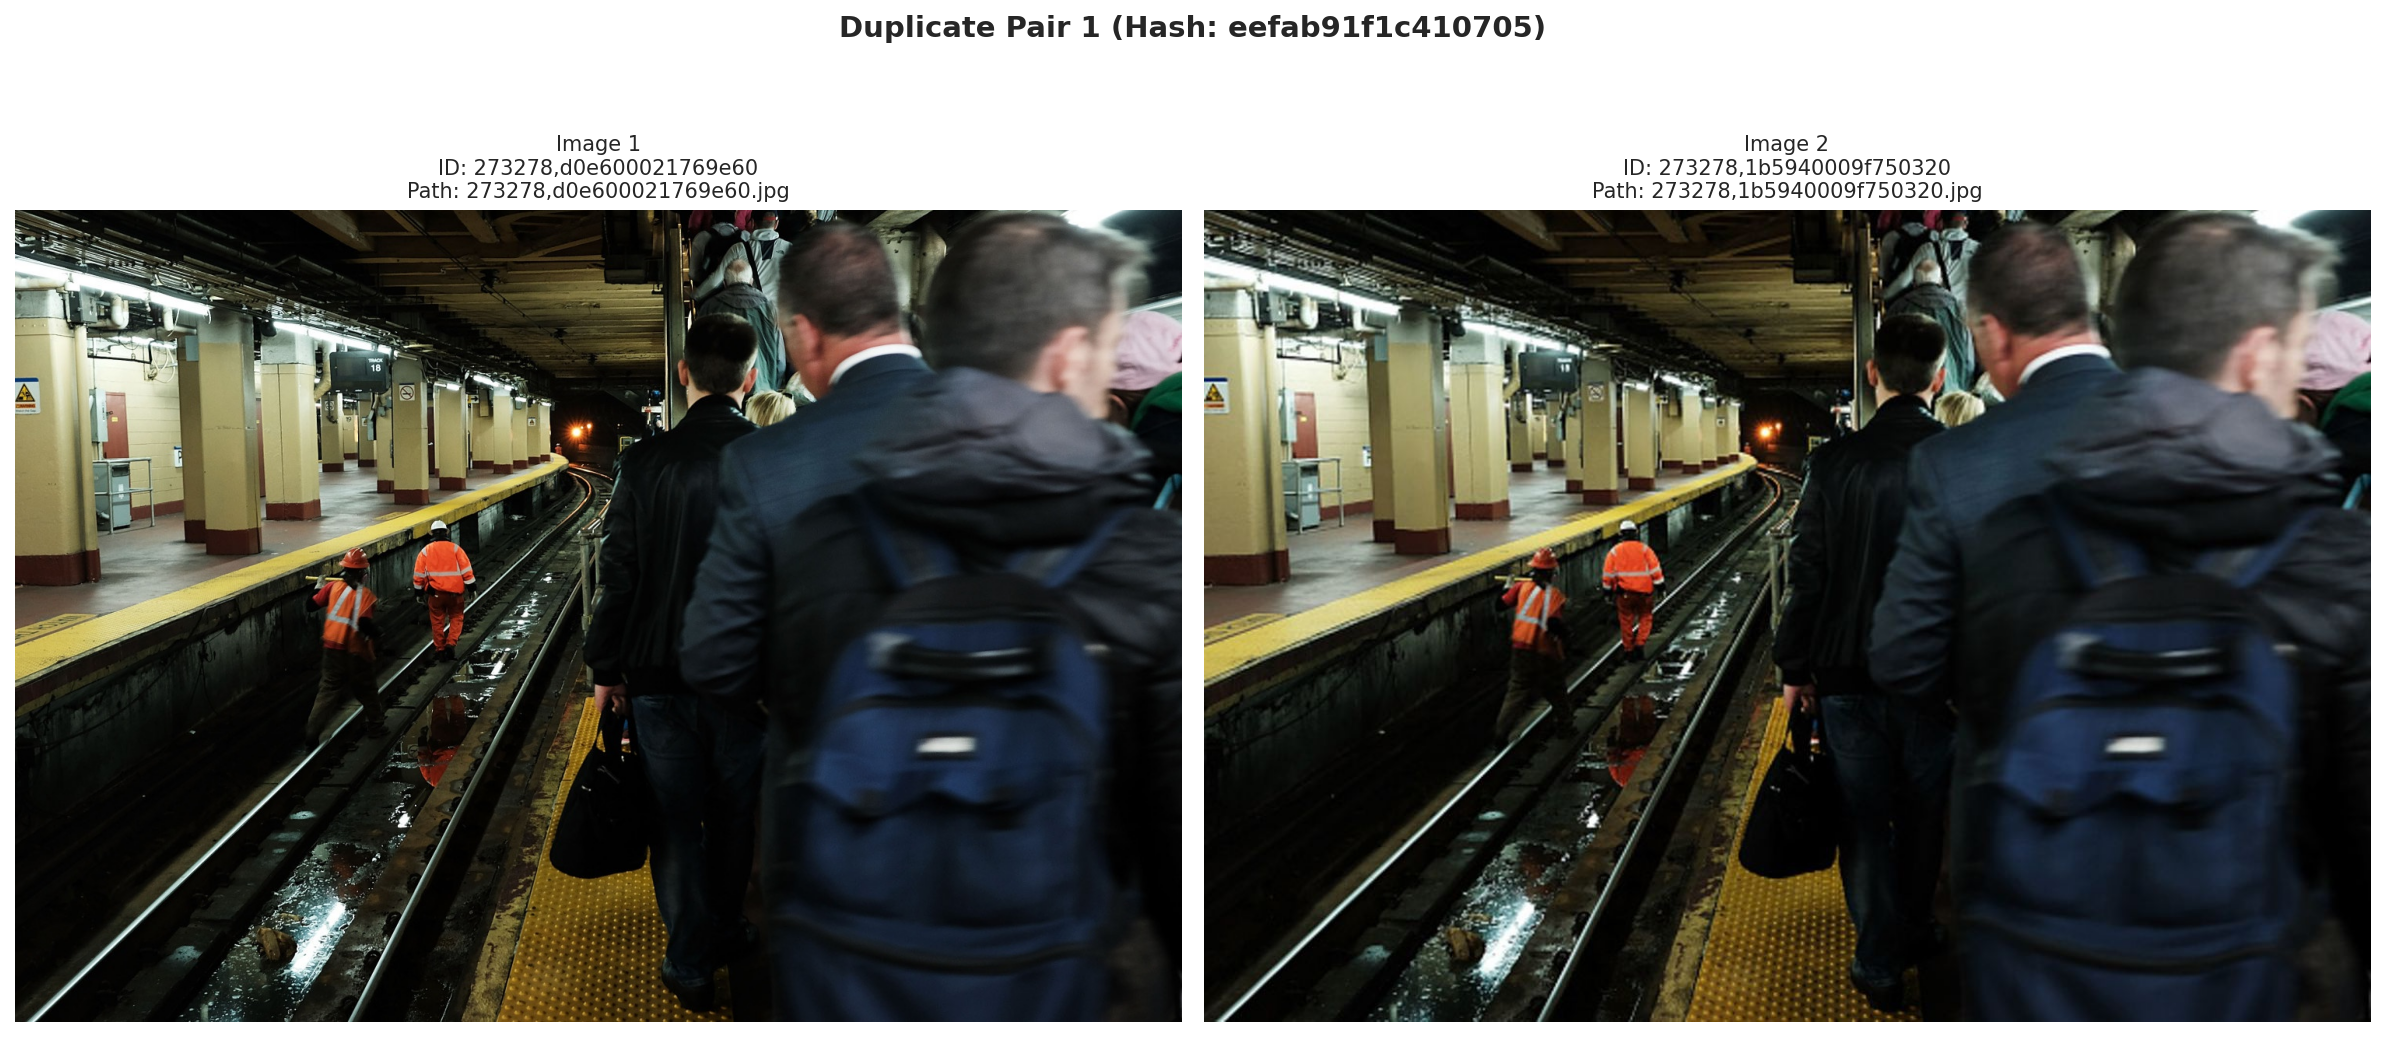

In [32]:
# === Visualize Duplicate Images ===

from IPython.display import Image as IPImage, display

# Load duplicate report
duplicate_file = OUTPUT_DIR / "duplicate_report.csv"
if duplicate_file.exists():
    df_duplicates = pd.read_csv(duplicate_file)
    
    if len(df_duplicates) > 0:
        print(f"Found {len(df_duplicates)} duplicate pair(s). Displaying images...\n")
        
        # Display each duplicate pair
        for idx, row in df_duplicates.iterrows():
            path1 = row['path_1']
            path2 = row['path_2']
            image_id1 = row['image_id_1']
            image_id2 = row['image_id_2']
            hash_val = row['hash']
            
            # Load images
            try:
                img1 = cv2.imread(path1)
                img2 = cv2.imread(path2)
                
                if img1 is None or img2 is None:
                    print(f"Warning: Could not load one or both images for pair {idx+1}")
                    continue
                
                # Convert BGR to RGB for matplotlib
                img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
                img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
                
                # Create figure with two subplots
                fig, axes = plt.subplots(1, 2, figsize=(16, 8))
                
                # Display first image
                axes[0].imshow(img1_rgb)
                axes[0].set_title(f"Image 1\nID: {image_id1}\nPath: {Path(path1).name}", fontsize=10)
                axes[0].axis('off')
                
                # Display second image
                axes[1].imshow(img2_rgb)
                axes[1].set_title(f"Image 2\nID: {image_id2}\nPath: {Path(path2).name}", fontsize=10)
                axes[1].axis('off')
                
                plt.suptitle(f"Duplicate Pair {idx+1} (Hash: {hash_val})", fontsize=14, fontweight='bold')
                plt.tight_layout()
                
                # Save the visualization
                output_path = OUTPUT_DIR / f"duplicate_pair_{idx+1}.png"
                plt.savefig(output_path, dpi=150, bbox_inches='tight')
                print(f"Saved visualization: {output_path}")
                
                # Display saved image in notebook
                display(IPImage(str(output_path)))
                
                plt.close()
                
            except Exception as e:
                print(f"Error processing duplicate pair {idx+1}: {e}")
                import traceback
                traceback.print_exc()
                continue
    else:
        print("No duplicates found in the report.")
else:
    print("Duplicate report file not found. Run Step 8 first.")


In [24]:
# === STEP 9: CrowdHuman Special Box Comparison Cell ===

vbox_sizes = []
fbox_sizes = []
hbox_sizes = []
vbox_truncation = []
fbox_truncation = []
hbox_truncation = []

for ann in all_annotations:
    img_w = ann['img_w']
    img_h = ann['img_h']
    
    for box in ann['gtboxes']:
        if 'vbox' in box:
            x, y, w, h = box['vbox']
            size = w * h
            vbox_sizes.append(size)
            if x < 0 or y < 0 or (x + w) > img_w or (y + h) > img_h:
                vbox_truncation.append(1)
            else:
                vbox_truncation.append(0)
        
        if 'fbox' in box:
            x, y, w, h = box['fbox']
            size = w * h
            fbox_sizes.append(size)
            if x < 0 or y < 0 or (x + w) > img_w or (y + h) > img_h:
                fbox_truncation.append(1)
            else:
                fbox_truncation.append(0)
        
        if 'hbox' in box:
            x, y, w, h = box['hbox']
            size = w * h
            hbox_sizes.append(size)
            if x < 0 or y < 0 or (x + w) > img_w or (y + h) > img_h:
                hbox_truncation.append(1)
            else:
                hbox_truncation.append(0)

comparison_data = {
    'box_type': [],
    'mean_size': [],
    'median_size': [],
    'truncation_rate': []
}

if vbox_sizes:
    comparison_data['box_type'].append('vbox')
    comparison_data['mean_size'].append(np.mean(vbox_sizes))
    comparison_data['median_size'].append(np.median(vbox_sizes))
    comparison_data['truncation_rate'].append(np.mean(vbox_truncation))

if fbox_sizes:
    comparison_data['box_type'].append('fbox')
    comparison_data['mean_size'].append(np.mean(fbox_sizes))
    comparison_data['median_size'].append(np.median(fbox_sizes))
    comparison_data['truncation_rate'].append(np.mean(fbox_truncation))

if hbox_sizes:
    comparison_data['box_type'].append('hbox')
    comparison_data['mean_size'].append(np.mean(hbox_sizes))
    comparison_data['median_size'].append(np.median(hbox_sizes))
    comparison_data['truncation_rate'].append(np.mean(hbox_truncation))

df_comparison = pd.DataFrame(comparison_data)
df_comparison.to_csv(OUTPUT_DIR / "vbox_vs_fbox_comparison.csv", index=False)

print("Box Type Comparison:")
print(df_comparison)


Box Type Comparison:
  box_type     mean_size  median_size  truncation_rate
0     vbox  41836.681157       3915.0         0.046624
1     fbox  64620.728401       6258.0         0.137250
2     hbox   6617.356299        660.0         0.036190


In [ ]:
# === STEP 10: Automatic EDA Summary Markdown Cell ===

# Calculate statistics
total_images = len(all_annotations)
total_objects = sum(ann['num_boxes'] for ann in all_annotations)
avg_objects_per_image = total_objects / total_images if total_images > 0 else 0

class_dist = df_class.set_index('class')['count'].to_dict()
person_count = class_dist.get('person', 0)
mask_count = class_dist.get('mask', 0)

small_object_threshold = 0.01  # 1% of image area
small_objects = sum(1 for ratio in bbox_area_ratios if ratio < small_object_threshold)
small_object_ratio = small_objects / len(bbox_area_ratios) if bbox_area_ratios else 0

avg_occlusion = np.mean(occlusion_scores) if occlusion_scores else 0
avg_truncation = np.mean(truncation_rates) if truncation_rates else 0

density_dist = density_counts.to_dict()
sparse_pct = (density_dist.get('sparse', 0) / total_images * 100) if total_images > 0 else 0
medium_pct = (density_dist.get('medium', 0) / total_images * 100) if total_images > 0 else 0
dense_pct = (density_dist.get('dense', 0) / total_images * 100) if total_images > 0 else 0
extreme_pct = (density_dist.get('extreme', 0) / total_images * 100) if total_images > 0 else 0

# Generate recommendations
recommendations = []

if small_object_ratio > 0.3:
    recommendations.append("High small-object ratio detected. Consider multi-scale training.")
else:
    recommendations.append("Small-object ratio is manageable. Standard training should work.")

if avg_occlusion > 0.3:
    recommendations.append("High occlusion detected. Consider DIoU-NMS or Soft-NMS.")
else:
    recommendations.append("Moderate occlusion. Standard NMS should work.")

if extreme_pct > 20:
    recommendations.append("High extreme density detected. Consider advanced training strategies.")
else:
    recommendations.append("Density is manageable. Standard training should work.")

if avg_truncation > 0.2:
    recommendations.append("High truncation rate. Ensure proper data augmentation.")
else:
    recommendations.append("Truncation rate is acceptable.")



# Generate markdown
md_content = f"""# CrowdHuman Dataset EDA Summary

## Dataset Overview
- **Total Images**: {total_images:,}
- **Total Objects**: {total_objects:,}
- **Average Objects per Image**: {avg_objects_per_image:.2f}

## Class Distribution
- **Person**: {person_count:,} ({person_count/total_objects*100:.1f}%)
- **Mask**: {mask_count:,} ({mask_count/total_objects*100:.1f}%)

![Class Distribution](./class_distribution.png)

*This plot shows the distribution of object classes in the dataset. The "person" class represents individual person detections, while "mask" represents crowd regions or other person-like objects that should be ignored during training.*

**Analysis**: The dataset has a significant class imbalance with ~80% person and ~20% mask annotations. This imbalance suggests that most annotations are valid person detections, while mask annotations (crowd regions) are less frequent but still substantial. During training, ensure proper handling of mask annotations to avoid false positives from crowd regions.

## Object Characteristics
- **Small Object Ratio** (<1% of image area): {small_object_ratio:.1%}
- **Average Occlusion Score**: {avg_occlusion:.3f}
- **Average Truncation Rate**: {avg_truncation:.1%}

![Objects per Image](./objects_per_image.png)

*Distribution of the number of objects per image. This histogram reveals the crowd density characteristics of the dataset, showing how many images contain few vs. many objects.*

**Analysis**: The distribution shows a right-skewed pattern typical of crowded scene datasets. Most images contain moderate numbers of objects, but there's a long tail with some images containing hundreds of objects. This extreme variation in object count requires robust training strategies that can handle both sparse and extremely dense scenes. The high maximum (391 objects) indicates severe crowding scenarios that will challenge detection models.

![Bounding Box Area Ratio](./bbox_area_ratio_hist.png)

*Histogram showing the ratio of bounding box area to total image area. Values closer to 0 indicate small objects, while values closer to 1 indicate objects that occupy most of the image. The log scale helps visualize the long tail of small objects.*

**Analysis**: The log-scale histogram reveals a heavy concentration of small objects (area ratio < 0.01), which aligns with the 57% small object ratio. This distribution indicates that the dataset contains many distant or partially visible people, making small object detection critical. The long tail suggests significant scale variation, requiring multi-scale feature extraction and appropriate anchor box design. Models must be capable of detecting objects spanning several orders of magnitude in size.

![Aspect Ratio Distribution](./aspect_ratio_hist.png)

*Distribution of bounding box aspect ratios (width/height). Values < 1 indicate taller objects (typical for standing people), while values > 1 indicate wider objects. This helps understand object shape characteristics.*

**Analysis**: The distribution shows a strong peak below 1.0, confirming that most bounding boxes are taller than they are wide, which is expected for standing people. The mean aspect ratio of ~0.58 indicates people are typically about 1.7 times taller than wide. However, there's variation including some wider boxes (possibly groups, sitting people, or partial views). This information is useful for designing anchor box aspect ratios and understanding pose variations in the dataset.

## Spatial Distribution

![Bounding Box Center Heatmap](./bbox_center_heatmap.png)

*Heatmap showing the spatial distribution of bounding box center points across normalized image coordinates. Warmer colors indicate regions with higher object density. This reveals where objects tend to be located in images (e.g., center vs. edges).*

**Analysis**: The heatmap reveals spatial bias in object locations. If objects cluster in the center, it suggests images are typically framed with people in the middle. If objects are distributed more evenly, it indicates diverse scene compositions. Edge clustering might indicate truncation or people entering/exiting frames. Understanding this spatial distribution helps with data augmentation strategies (e.g., whether to use center cropping) and can inform where to focus detection efforts during inference.

## Crowding & Occlusion Analysis

![IoU Distribution](./iou_distribution.png)

*Distribution of Intersection over Union (IoU) values between pairs of bounding boxes in the same image. Higher IoU values indicate more overlapping objects, which is characteristic of crowded scenes. This metric helps quantify the level of occlusion in the dataset.*

**Analysis**: The IoU distribution shows the pairwise overlap characteristics. A distribution heavily skewed toward 0 indicates mostly non-overlapping objects, while higher IoU values indicate severe crowding. The mean IoU of ~0.01 suggests most object pairs don't overlap significantly, but the maximum IoU near 1.0 indicates some extreme cases of near-complete overlap. This pattern is typical for crowded scenes where most people are separate but some groups are tightly packed. High IoU cases will challenge NMS algorithms and may require specialized handling.

![Occlusion Score Distribution](./occlusion_score_hist.png)

*Distribution of occlusion scores per image, calculated as the mean of maximum IoU values for each bounding box. Higher scores indicate images with more severe occlusion, where objects heavily overlap with each other.*

**Analysis**: The occlusion score distribution shows how occlusion severity varies across images. An average score of ~0.28 indicates moderate occlusion levels overall. If the distribution is right-skewed, most images have low occlusion but some have severe cases. If it's more uniform, occlusion is consistently moderate across the dataset. Images with high occlusion scores (>0.5) will be particularly challenging and may benefit from specialized training techniques or post-processing. This metric helps identify which images might need special attention during training or validation.

![Truncation Rate Distribution](./truncation_rate.png)

*Distribution of truncation rates per image, showing the proportion of bounding boxes that extend beyond image boundaries. Higher truncation rates indicate more objects are partially cut off at image edges.*

**Analysis**: The truncation rate distribution reveals how often objects are cut off at image boundaries. An average truncation rate of ~22% indicates that about one-fifth of objects are partially outside the frame. If the distribution shows many images with high truncation (>50%), it suggests the dataset contains many edge cases where people are entering/exiting frames. This is common in surveillance or street scene datasets. High truncation requires careful handling during training to avoid penalizing valid but partial detections, and may necessitate special loss functions or evaluation metrics that account for truncation.

## Crowd Density Distribution
- **Sparse** (<5 objects): {sparse_pct:.1f}%
- **Medium** (5-14 objects): {medium_pct:.1f}%
- **Dense** (15-29 objects): {dense_pct:.1f}%
- **Extreme** (≥30 objects): {extreme_pct:.1f}%

![Density Distribution](./density_distribution.png)

*Bar chart showing the distribution of images across different crowd density levels. This classification helps understand the dataset composition and identify which density levels are most common.*

**Analysis**: The density distribution shows a relatively balanced split across medium, dense, and extreme categories (~32-33% each), with sparse images being rare (~3%). This balanced distribution is beneficial for training as the model will see diverse crowd scenarios. However, the high proportion of extreme density images (33%) means the model must be robust to very crowded scenes. The near-equal distribution suggests the dataset is well-designed for crowd detection tasks, but the scarcity of sparse images might make the model less robust to scenes with few people. Consider data augmentation or targeted sampling to ensure sparse scenarios are adequately represented.

## Image Quality Analysis

![Brightness Distribution](./brightness_hist.png)

*Distribution of image brightness values calculated as the mean grayscale intensity. This helps identify if the dataset has consistent lighting conditions or contains images with varying brightness levels (e.g., indoor vs. outdoor scenes).*

**Analysis**: The brightness distribution reveals lighting conditions across the dataset. A narrow distribution suggests consistent lighting (e.g., all outdoor daytime scenes), while a wide distribution indicates diverse conditions (indoor/outdoor, day/night, various weather). The mean brightness of ~113 (on 0-255 scale) suggests generally well-lit scenes, but variation indicates the dataset includes different lighting scenarios. This diversity is beneficial for generalization but may require normalization or adaptive preprocessing. If the distribution is bimodal, it might indicate distinct indoor/outdoor subsets that could benefit from domain adaptation techniques.

![Blur Score Distribution](./blur_score_hist.png)

*Distribution of blur scores calculated using Laplacian variance. Higher values indicate sharper images, while lower values indicate blurrier images. This metric helps assess image quality and identify potential data quality issues.*

**Analysis**: The blur score distribution indicates image sharpness quality. A distribution with most values above 100 typically indicates sharp images suitable for detection. Very low scores (<50) suggest motion blur or poor focus, which can degrade detection performance. The mean blur score and standard deviation reveal overall image quality. If there's a significant tail of low blur scores, those images may need special handling or could be candidates for exclusion or deblurring preprocessing. High variance in blur scores suggests inconsistent image quality that might benefit from quality-based sampling or augmentation strategies.

## Annotation Attributes Analysis

![Extra Ignore Flag Distribution](./extra_ignore_distribution.png)

*Distribution of ignore flags from the "extra" attribute. Value 0 means the object should be used for training, while 1 means it should be ignored (e.g., crowd regions, reflections, or other non-person objects).*

**Analysis**: The ignore flag distribution shows the proportion of annotations that should be excluded from training. If most flags are 0, the dataset has high-quality annotations. If a significant portion is 1, it indicates many ambiguous cases (crowds, reflections, etc.) that annotators marked for exclusion. This is important for training - ensure your data loader properly filters ignored annotations to avoid learning from invalid examples. The ratio of ignored to non-ignored annotations also affects the effective dataset size and class balance.

![Extra Occlusion Distribution](./extra_occ_distribution.png)

*Distribution of occlusion levels from the "extra" attribute. This shows the annotated occlusion severity for each object, providing ground truth occlusion information beyond what can be inferred from bounding box overlaps.*

**Analysis**: The occlusion level distribution from annotations provides ground truth occlusion information. The mean occlusion level of ~0.72 (if on a 0-1 scale) indicates significant occlusion in the dataset. This annotation-level occlusion data is more accurate than IoU-based estimates because annotators can identify occlusion even when bounding boxes don't overlap (e.g., objects behind others). Understanding the distribution helps with training strategies - highly occluded objects might need different loss weights or could be used for occlusion-aware training. The distribution pattern (uniform vs. skewed) reveals whether occlusion is consistent or varies dramatically across objects.

![Head Ignore Flag Distribution](./head_ignore_distribution.png)

*Distribution of ignore flags for head annotations from the "head_attr" attribute. This indicates which head bounding boxes should be ignored during training, typically due to poor visibility or annotation quality.*

**Analysis**: The head ignore flag distribution is critical for head-related tasks (age/gender estimation, face recognition). If most flags are 0, most heads are usable. If a significant portion is 1, many heads have visibility issues. The ratio of ignored heads affects the effective dataset size for head-based tasks. This is particularly important for age/gender estimation models that rely on head visibility. Ensure your training pipeline properly handles ignored head annotations to avoid learning from poor-quality head regions.

![Head Occlusion Distribution](./head_occ_distribution.png)

*Distribution of head occlusion levels from the "head_attr" attribute. This provides specific occlusion information for head regions, which is important for tasks like age/gender estimation that rely on head visibility.*

**Analysis**: Head occlusion levels are crucial for age/gender estimation tasks. The mean head occlusion of ~0.28 indicates moderate head visibility overall. This is better than body occlusion (0.72), suggesting heads are often more visible than full bodies in crowded scenes. However, any significant head occlusion will impact age/gender prediction accuracy. The distribution shows how many heads are fully visible vs. partially/fully occluded. For age/gender models, consider filtering or down-weighting highly occluded heads during training, or use occlusion-aware architectures that can handle partial visibility.

![Head Unsure Flag Distribution](./head_unsure_distribution.png)

*Distribution of "unsure" flags for head annotations. This indicates cases where annotators were uncertain about the head annotation quality, which may require special handling during training.*

**Analysis**: The "unsure" flag distribution reveals annotation confidence. If most flags are 0, annotators were confident in their head annotations. If a significant portion is 1, there are many ambiguous cases. The ~0.7% unsure rate (3263 out of 439046) suggests high annotation confidence overall, but these uncertain cases might benefit from special handling - either exclusion from training, lower loss weights, or separate evaluation. For production systems, unsure annotations might require human review or conservative confidence thresholds.

## Model Recommendations

### NMS Strategy
- **Soft-NMS vs DIoU-NMS**: {'DIoU-NMS or Soft-NMS recommended' if avg_occlusion > 0.3 else 'Standard NMS should work'}
  
  *Reason: {'The average occlusion score of ' + f'{avg_occlusion:.3f}' + ' indicates significant object overlap. DIoU-NMS or Soft-NMS better handle overlapping detections by considering distance and overlap penalties, reducing false positives in crowded scenes.' if avg_occlusion > 0.3 else 'The average occlusion score of ' + f'{avg_occlusion:.3f}' + ' indicates moderate overlap. Standard NMS with appropriate IoU threshold should be sufficient for this dataset.'}*

### Training Configuration
- **Multi-scale Training**: {'ON (recommended)' if small_object_ratio > 0.3 else 'OFF (optional)'}
  
  *Reason: {'With ' + f'{small_object_ratio:.1%}' + ' of objects being small (<1% of image area), multi-scale training helps the model learn to detect objects at various scales, improving performance on small and distant objects.' if small_object_ratio > 0.3 else 'With ' + f'{small_object_ratio:.1%}' + ' of objects being small, the dataset has manageable object size distribution. Multi-scale training is optional but may still provide marginal improvements.'}*

- **Mosaic/MixUp**: {'Suitable (recommended)' if avg_occlusion < 0.5 else 'Use with caution'}
  
  *Reason: {'The average occlusion score of ' + f'{avg_occlusion:.3f}' + ' indicates moderate overlap levels. Mosaic and MixUp augmentations can help the model learn to handle partial occlusions and improve generalization without significantly distorting the already complex occlusion patterns.' if avg_occlusion < 0.5 else 'The average occlusion score of ' + f'{avg_occlusion:.3f}' + ' indicates high occlusion. Mosaic/MixUp may introduce unrealistic occlusion patterns that could confuse the model. Use with caution and monitor validation performance.'}*

## Detailed Recommendations
{chr(10).join(f'- {rec}' for rec in recommendations)}

## Generated Files
All analysis outputs have been saved to `./eda_outputs/` directory.
"""

# Save summary
with open(OUTPUT_DIR / "eda_summary.md", 'w', encoding='utf-8') as f:
    f.write(md_content)

print("EDA Summary generated successfully!")
print(f"Saved to: {OUTPUT_DIR / 'eda_summary.md'}")


EDA Summary generated successfully!
English version saved to: eda_outputs/eda_summary_en.md
Korean version saved to: eda_outputs/eda_summary_ko.md
